---
# Examples of Expectation-Maximisation classification in 2-D with cluster trajectories 
---

In this script, we use the Expectation-Maximisation (EM) method to classify datasets made of two or three overlapping ellipsoidal gaussian blobs. 
The overlap between clusters makes the classification non trivial. This leads to an interesting visual exploration 
of the properties of the algorithm.   


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors


from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

import random

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

import seaborn as sns
sns.set()

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


# Part I:  A few useful functions

Let us first define several functions used for generating the classification examples in the last section of the script.

### Data normalization


In [2]:
def normalize_dataset(X, nbins):
    X = StandardScaler().fit_transform(X)
    x_min = 1.1 * X[:,0].min()
    x_max = 1.1 * X[:,0].max()
    y_min = 1.1 * X[:,1].min()
    y_max = 1.1 * X[:,1].max()

    # Generate a spatial grid 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    return (X, Xgrid, xx, yy, x_min, x_max, y_min, y_max)

### Expectation-Maximisation algorithm

This version of the EM algorithm saves the classifier and the cluster positions at each iteration. 

For visualisation purposes, the initial position of each cluster is provided by the user. In the first iteration, 
the nearest-neighbor classifier is used with the predefined cluster positions to produce an initial classification. 
The EM algorithm is used in the following iterations. In the scikit-learn implementation of the EM 
algorithm (sklearn.mixture.GaussianMixture), the initial cluster positions are chosen randomly or using the K-Means algorithm.    

In [3]:
def expectation_maximisation(X, n_clusters, X_c0=None):
    # Initialisations
    (n_data, n_dim) = X.shape
    n_iter = 8
    
    # Arrays used for saving, at each iteration, the cluster centers, their weights and the 
    # classes of the datapoints. 
    X_c = np.zeros((n_iter+1, n_clusters, n_dim))
    weights = np.full((n_iter+1, n_clusters),1./n_clusters)
    C = np.zeros((n_iter, n_data), dtype=int)
    
    # Assign predefined cluster centers 
    X_c[0,:,:] = X_c0
    
    classifiers = []
    for i in range(n_iter):
        (C[i,:], X_c[i+1,:,:], weights[i+1,:], clf) = update_cluster_centers(i, X, X_c[i,:,:], weights[i,:])
        classifiers.append(clf)

    return (C, X_c, classifiers)


def update_cluster_centers(i, X, x_c, weights):  
    n_clusters = x_c.shape[0]
    n_data = X.shape[0]
    
    if (i==0):
        # Nearest neighbor classification
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(x_c, np.arange(n_clusters))
        class_new = clf.predict(X)
        
        # Update the center position of each cluster by computing the center of gravity of its datapoints 
        xc_new = np.zeros(x_c.shape)
        weights_new = np.zeros(n_clusters)
        for k in range(n_clusters):
            indx = np.argwhere(class_new==k).ravel()
            weights_new[k] = len(indx)
            xc_new[k,:] = np.mean(X[indx,:], axis=0)         
        weights_new= weights_new/n_data

        
    else:
        # EM classification (one iteration)
        clf = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full', means_init=x_c, 
                                      weights_init=weights, warm_start=True, max_iter=1)
        
        class_new = clf.fit_predict(X)    
        weights_new = clf.weights_
        xc_new = clf.means_

    return (class_new, xc_new, weights_new, clf)
    

### Function that finds the influence zone of each cluster

In [4]:
def find_influence_zones(clf, Xgrid, xx):  
    
    c = clf.predict(Xgrid)
    c = c.reshape(xx.shape)
  
    return c

### Function that displays a mosaic with the classification results

In [5]:
def display_classification_results(X, y, X_c, C, Xgrid, xx, yy, figName):

    cm_background = ListedColormap(['#7777FF', '#9999FF', '#BBBBFF'])
    cm_dots = ListedColormap(['#00FF00', '#0000FF', '#FFFF00'])
    cm_dots2 = ListedColormap(['#000000', '#555555', '#AAAAAA'])

    n_clusters = C.ravel().max() + 1
    
    fig, axs = plt.subplots(3,3, figsize=(15,15), sharex=True, sharey=True) 
    
    # Initial conditions 
    for k in range(9):
        ax = axs.ravel()[k]

        if (k==0):
            # Initial conditions
            ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_dots, edgecolors='k', facecolor='w')
            ax.set_title('Dataset', fontsize=18, color='k')
        elif (k<8):
            # EM classification results
            Z = find_influence_zones(classifiers[k-1], Xgrid, xx)
            if (n_clusters==2):
                ax.pcolormesh(xx, yy, Z, cmap=cm_background, norm=colors.Normalize(0., 1.), zorder=0)
            else:
                ax.pcolormesh(xx, yy, Z, cmap=cm_background, norm=colors.Normalize(0., 2.), zorder=0)
                
            ax.contour(xx, yy, Z, [0.5, 1.5], linewidths=2., colors='yellow') 
            ax.scatter(X[:, 0], X[:, 1], c=C[k-1,:], s=50, cmap=cm_dots2, edgecolors='k')
            
            ax.set_title('Iteration : %d' % (k), fontsize=18, color='k')
            ax.plot(X_c[0:k,:,0],X_c[0:k, :, 1], linestyle='-', linewidth=4, color='w')
            ax.scatter(X_c[k-1,:,0],X_c[k-1, :, 1], s=150, marker='o', color='w')

        else:
            # Initial conditions
            ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_dots, edgecolors='k', facecolor='w')
            ax.contour(xx, yy, Z, [0.5, 1.5], linewidths=2., colors='k') 
            ax.set_title('Iteration : %d  (over dataset)' % (k), fontsize=18, color='k')                
            
        ax.set_xlim([x_min,x_max])
        ax.set_ylim([y_min,y_max])

        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.grid(None)  
        ax.grid(None) 
    
    fig.tight_layout()
        
    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')

# Part II:  Examples of Expectation-Maximisation classification

## Example I: Two overlapping ellipsoidal gaussian blobs

The clusters have the same numbers of datapoints but different covariance matrices.

In [6]:
# Number of datapoints in each cluster
N_samples = 150

# First gaussian 
center = [[0, 0]]
X, y = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, 0.2], [0.2, 1]]
X = np.dot(X, transformation)

# Second gaussian 
center = [[0, 0]]
X2, y2 = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.5], [-0.5, 1]]
X2 = np.dot(X2, transformation) + [[2,2]]
y2 = y2 + 1

X = np.vstack((X, X2))
y = np.hstack((y, y2))


Normalize the dataset

In [7]:
# Number of spatial bins used in each spatial direction
nbins = 200

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

### Classify the dataset

In this example, we choose distant starting positions for the cluster centers. The positions are not
within the clusters in order to make convergence effects more visible.

We also disable convergence warnings as we iterate over single iterations. 

In [8]:
simplefilter("ignore", category=ConvergenceWarning)

n_clusters = 2

# Cluster starting positions
X_c0 = np.array([[2, -2],[-2, 2]])

# EM classification
(C, X_c, classifiers) = expectation_maximisation(X, n_clusters, X_c0=X_c0)


The following figure shows the results of successive iterations of the EM algorithm. 

The second panel (Iteration=1) shows the initial cluster centers as white dots and the initial nearest-neighbor 
classification. The EM classification results are shown in the following panels. The white dots indicate the 
current cluster centroids and the white lines show their trajectories over successive iterations.

The last panel shows the solution near convergence. The two center positions are located very close to the two 
ellipsoidal gaussian blobs. 

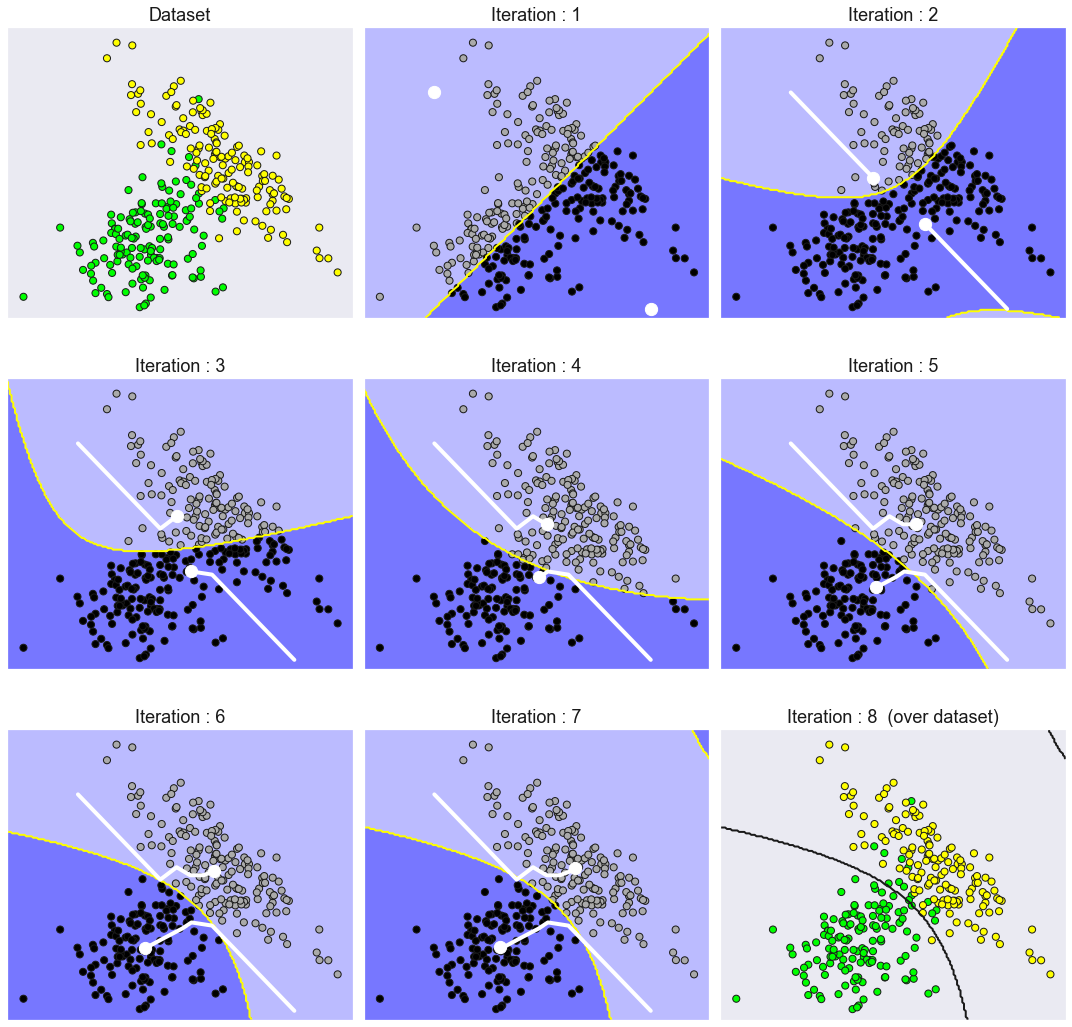

In [9]:
# Compare classification results
figName = '14.3.1_ME_example_with_2_clusters'
display_classification_results(X, y, X_c, C, Xgrid, xx, yy, figName)

## Example II: Three ellipsoidal gaussian blobs

The clusters have the same numbers of datapoints and share the same covariance matrix.


In [10]:
# Number of datapoints in each cluster
N_samples = 150

# First gaussian 
center = [[0, 0]]
X, y = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.2], [-0.2, 1]]
X = np.dot(X, transformation)

# Second gaussian 
center = [[0, 0]]
X2, y2 = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.2], [-0.2, 1]]
X2 = np.dot(X2, transformation) + [[2, 2]]
y2 = y2 + 1

# Third gaussian 
center = [[0, 0]]
X3, y3 = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.2], [-0.2, 1]]
X3 = np.dot(X3, transformation) + [[0, 5]]
y3 = y3 + 2

X = np.vstack((X, X2, X3))
y = np.hstack((y, y2, y3))


Normalize the dataset

In [11]:
# Number of spatial bins used in each spatial direction
nbins = 200

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

### Classify the dataset

Once again, we select distant starting positions for the cluster centers. The positions are chosen in order to make 
convergence effects more visible.

In [12]:
n_clusters = 3

# Cluster starting positions
X_c0 = np.array([[-1.5, 1.5],[0, 0],[1.5, -1.5]])

# EM classification
(C, X_c, classifiers) = expectation_maximisation(X, n_clusters, X_c0=X_c0)


The following figure shows the results of successive iterations. 

Convergence is faster in this more complex classification problem. The cluster positions barely 
change after the fifth iteration. 


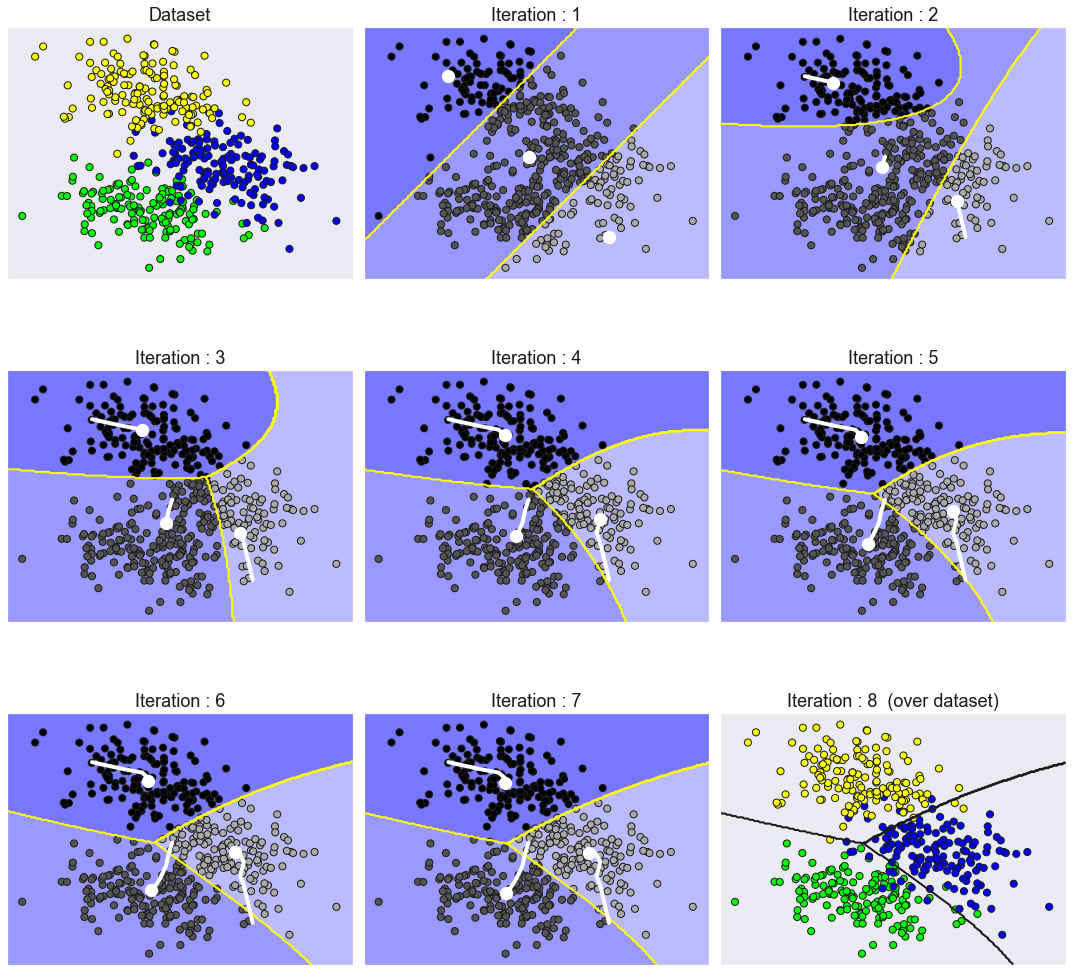

In [13]:
# Compare classification results
figName = '14.3.2_ME_example_with_3_clusters'
display_classification_results(X, y, X_c, C, Xgrid, xx, yy, figName)